In [3]:
import numpy as np
import tensorflow as tf
import os
import json
from gensim.models import Word2Vec, FastText
import tqdm.notebook as tqdm

In [4]:
def read(path_with_everything: str):
    codes = []
    tags = []
    for contest_folder in os.listdir(path_with_everything):
        contest_path = os.path.join(path_with_everything, contest_folder)
        if not os.path.isdir(contest_path):
            continue
        meta_json = json.load(open(os.path.join(contest_path, 'meta.json'), 'r', encoding='utf-8'))
        submissions = meta_json['Submissions']
        for s in submissions.values():
            flattened_tree_path = os.path.join(contest_path, 'java', f'{s["Id"]}.java.ast.stm.flat')
            if not os.path.exists(flattened_tree_path):
                continue

            tags.append(s['Tags'])
            statements = open(flattened_tree_path, 'r', encoding='utf-8').read().strip('\n').split('\n\n')
            codes.append([])
            for stm in statements:
                codes[-1].append([])
                for i in stm.split('\n'):
                    try:
                        token, children = i.split('\t')
                        children = tuple(map(int, children.split())) if children else ()
                        codes[-1][-1].append((token, children))
                    except:
                        print(flattened_tree_path, stm, i, sep='\n\n')
    return codes, tags

In [5]:
codes, tags = read('utils/samples/Codeforces/Yoink-Data')

In [127]:
for code in codes:
    for statement in code:
        for node, children in statement:
            for child in children:
                _ = statement[child]

IndexError: list index out of range

In [6]:
vocab = set()
for code in codes:
    for statement in code:
        for token, _ in statement:
            vocab.add(token)
len(vocab)

21777

In [57]:
vocab = list(vocab)
token_to_id = {j:i for i, j in enumerate(vocab)}

In [96]:
labels = set()
for tag_list in tags:
    for tag in tag_list:
        labels.add(tag)
labels = list(labels)
label_to_id = {label: i for i, label in enumerate(labels)}

In [58]:
dim = 192

In [59]:
w2v_model = Word2Vec.load('utils/java.w2v')
w2v_wv = w2v_model.wv
w2v_embeddings = np.array([w2v_wv[i] if i in w2v_wv else np.zeros((dim,)) for i in vocab])

In [60]:
ft_model = FastText.load('utils/java.ft')
ft_wv = ft_model.wv
ft_embeddings = np.array([ft_wv[i] if i in ft_wv else np.zeros((dim,)) for i in vocab])

In [61]:
print(w2v_embeddings[:10])
print(ft_embeddings[:10])

[[ 0.30367     0.10270511 -0.4131966  ... -0.0845805  -0.01419335
  -0.17824554]
 [ 0.05798344 -0.05268424  0.10425927 ...  0.09329583  0.12661745
  -0.04027711]
 [-0.12143497 -0.05300783  0.02445679 ...  0.06512076 -0.01052139
  -0.04133365]
 ...
 [ 0.07665545  0.00831272 -0.0460017  ...  0.08507466  0.03281435
   0.19442406]
 [ 0.02235229 -0.09181054 -0.01255795 ...  0.01226202  0.03656536
   0.10051543]
 [-0.06773315 -0.04321453  0.0452197  ...  0.05534829 -0.02168257
   0.03712261]]
[[ 0.2969489   0.16750643  1.1966213  ... -0.5208342  -0.38895652
  -1.9641588 ]
 [-0.2575132   0.23734853 -0.12299175 ...  0.34764686 -0.925342
  -1.0036569 ]
 [-0.7809004   0.5879315   0.43735573 ...  1.0293046  -2.060124
  -1.3344779 ]
 ...
 [ 0.01664163 -0.00615533 -0.00461163 ...  0.19570808 -0.02923601
   0.0089868 ]
 [-0.09287308 -0.29611906  0.0054104  ... -0.16896923 -0.06315529
  -0.05832468]
 [ 0.19434837  0.7019075   0.585249   ... -0.12767608 -0.05076283
  -0.6632441 ]]


In [62]:
print(sum(i in w2v_wv for i in vocab), len(vocab))
print(sum(i in ft_wv for i in vocab), len(vocab))

21777 21777
21777 21777


In [63]:
print(len(w2v_model.wv.key_to_index))
print(len(ft_model.wv.key_to_index))

21777
21777


In [90]:
vectorized = []
indices = []
max_code_len = -1
max_statement_len = -1

statements_hist = []

for code in codes:
    vectorized.append([])
    indices.append([])
    max_code_len = max(max_code_len, len(code))
    statements_hist.append(len(code))
    for statement in code:
        vectorized[-1].append([])
        indices[-1].append([])
        max_statement_len = max(max_statement_len, len(statement))
        for token, _ in statement:
            vectorized[-1][-1].append(token_to_id[token] + 2)
            indices[-1][-1].append(_)

In [77]:
print(vectorized[:10])
print(indices[:10])

[[[18667, 10919, 11059, 16639], [3709, 10919, 11059, 9419, 11712, 11059, 18296, 17430, 11059, 18483, 7569], [18098, 17430, 11059, 19363, 11842, 11059, 15339, 5719, 17430, 11059, 19363, 12875, 21341, 3941, 4151, 11059, 3549], [18098, 1053, 11059, 7953, 11842, 11059, 7352], [5492, 3941, 15339, 11059, 3508], [18098, 1053, 11059, 7953, 11842, 11059, 192], [5492, 3941, 15339, 11059, 3508], [18098, 1053, 11059, 1638, 11842, 11059, 8561, 12097, 1053, 11059, 7953, 3526, 17296, 9064, 21341, 11059, 7352, 14081, 499, 14164], [14186, 11167, 19642, 1053, 11059, 7953, 11842, 11059, 19606, 14081, 499, 12995, 3526, 17296, 9585, 21341, 11059, 19606, 21341, 11059, 7352, 21341, 11059, 19606, 17046, 8993, 17296, 16398, 16092], [5397, 9690, 17296, 1045, 21341, 11059, 8561, 10098, 21341, 11059, 19606], [5492, 3941, 15339, 11059, 3508], [5397, 9690, 17296, 1045, 21341, 11059, 8561, 10098, 14081, 499, 2586, 14081, 499, 2586], [5397, 9690, 17296, 1045, 21341, 11059, 8561, 10098, 3526, 17296, 9064, 21341, 11059

(array([2.397e+03, 4.667e+03, 1.836e+03, 1.633e+03, 1.436e+03, 1.000e+03,
        7.240e+02, 6.220e+02, 5.450e+02, 4.710e+02, 4.130e+02, 3.460e+02,
        3.220e+02, 2.170e+02, 2.060e+02, 1.950e+02, 1.660e+02, 1.400e+02,
        9.300e+01, 1.040e+02, 7.200e+01, 9.000e+01, 6.200e+01, 5.400e+01,
        4.100e+01, 4.200e+01, 2.600e+01, 2.100e+01, 1.400e+01, 4.100e+01,
        2.600e+01, 1.500e+01, 1.600e+01, 8.000e+00, 4.000e+00, 7.000e+00,
        9.000e+00, 1.000e+01, 2.000e+00, 3.000e+00, 7.000e+00, 2.000e+00,
        0.000e+00, 6.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 3.000e+00,
        9.000e+00, 5.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        5.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 6.000e+00, 0.000e+0

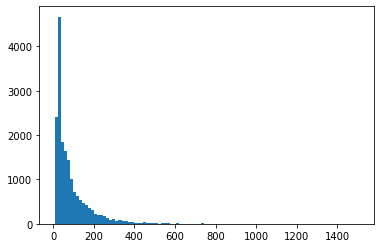

In [91]:
import matplotlib.pyplot as plt

plt.hist(statements_hist, bins=100)

In [99]:
he_tags = []
for tag_list in tags:
    he_tags.append([0] * len(labels))
    for tag in tag_list:
        he_tags[-1][label_to_id[tag]] = 1
he_tags = np.array(he_tags)

In [100]:
print(he_tags[:10])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [78]:
print(max_code_len)
print(max_statement_len)

1507
2019


In [106]:
emb_size = 192
input_dim = len(vocab) + 2
weights = np.zeros((input_dim, emb_size))

for i, token in enumerate(vocab):
    try:
        weights[i + 2] = ft_embeddings[i]
    except:
        pass

embedding = tf.keras.layers.Embedding(input_dim, emb_size, name='token_embedding', mask_zero=True)
embedding.build((None, None, None))
embedding.set_weights([weights])
embedding.trainable = False

In [116]:
encoder_dim = 128
encoder_inputs = tf.keras.layers.Input((None, None, emb_size))
encoder = tf.keras.layers.Dense(encoder_dim)(encoder_inputs)
encoder_model = tf.keras.Model(inputs=encoder_inputs, outputs=encoder)

In [108]:
inputs = tf.keras.layers.Input((None, encoder_dim), name='Inputs')
x = tf.keras.layers.Dropout(0.1, name='Embedding_Dropout')(inputs)
x = tf.keras.layers.Bidirectional(
        tf.keras.layers.RNN(
            tf.keras.layers.StackedRNNCells([
            tf.keras.layers.GRUCell(units=256),
            tf.keras.layers.GRUCell(units=256),
        ])), name='Double_Bidirectional_GRU')(x)
x = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.swish)(x)
x = tf.keras.layers.Dense(units=len(labels), activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=x, name='ASTNN')

In [126]:
def batch(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

epochs = 10
batch_size = 8

pooling = tf.keras.layers.GlobalMaxPooling1D()
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

for epoch in tqdm.trange(epochs):
    vectorized_batches = batch(vectorized, batch_size)
    indices_batches = batch(indices, batch_size)
    he_tags_batches = batch(he_tags, batch_size)
    pbar = tqdm.tqdm(enumerate(zip(vectorized_batches, indices_batches, he_tags_batches)), total=len(vectorized) // batch_size)
    for step, (vectorized_batch, indices_batch, he_tags_batch) in pbar:
        max_len = max(len(j) for i in vectorized_batch for j in i)
        code_batch = tf.keras.preprocessing.sequence.pad_sequences(
            [tf.keras.preprocessing.sequence.pad_sequences(i, padding='post', maxlen=max_len) for i in vectorized_batch],
            padding='post'
        )

        with tf.GradientTape() as tape:
            encoded = encoder_model(embedding(code_batch), training=True)
            encoded_as_list = [[[encoded[i, j, k] for k in range(max_len)] for j in range(code_batch.shape[1])] for i in range(len(code_batch))]
            for i in range(len(indices_batch)):
                for j in range(len(indices_batch[i])):
                    for k in range(len(indices_batch[i][j]) - 1, -1, -1):
                        children = indices_batch[i][j][k]
                        if not children:
                            continue
                        try:
                            encoded_as_list[i][j][k] = tf.reduce_sum([encoded_as_list[i][j][k],
                                                                *(encoded_as_list[i][j][l] for l in children)], axis=0)
                        except Exception as e:
                            print(children)
                            print(len(encoded_as_list[i][j]))
                            raise e

            pooled = [[pooling(j) for j in i] for i in encoded_as_list]
            logits = model(pooled, training=True)
            loss_value = loss_fn(he_tags_batch, logits)

        grads = tape.gradient(loss_value, model.trainable_weights + encoder_model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights + encoder_model.trainable_weights))
        pbar.set_description(str(loss_value.numpy()))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2272 [00:00<?, ?it/s]

(67,)
64


IndexError: list index out of range